## DATA ANALYSIS FOR THREE-COPY MEASUREMENTS in 2022 on IBM Q devices

In [1]:
#18/05/21: stripped down version of IBM code for running locally on IBM Qsystem 1
import math
import certifi
# Importing standard Qiskit libraries and configuring account
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from scipy import stats

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer,BasicAer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity



In [2]:
#choose which comp to look at
# cname='ibm_auckland'
# cname='ibmq_guadalupe'
# cname='ibmq_mumbai'
# cname='ibmq_brooklyn'
cname='ibm_cairo'
cname='ibmq_ehningen'

X intercept = -0.02194143121525057
Y intercept = 0.018103997982638516
x estimates =  [0.011084487709905055, 0.028234791573785094, 0.03245916097661913, -0.040448581022530274, 0.01936987851092285, 0.07283173483779971, -0.009741144930675847, 0.020239139760013933, 0.03731508882939888, 0.048069755907267135]
error bars =  [0.009078928821046658, 0.009351213265007022, 0.00939593398021475, 0.009916826130395132, 0.009434659935656547, 0.009320434598723521, 0.009265296188782128, 0.00975870312348343, 0.009406440406995273, 0.009877872616092786]
y estimates =  [-0.09969027013871985, -0.011486769950958547, -0.04694487378439897, 0.006554392331022562, -0.004739060410164969, -0.03509723957283901, -0.015936048526863086, -0.055536618167062755, -0.04672491603796545, 0.12856142443156487]
error bars =  [0.010351628641181897, 0.010957818048175501, 0.010094069859950065, 0.010319331720339933, 0.010727380664257175, 0.010251047240712548, 0.010055501327124976, 0.010703869102296417, 0.010108193598424832, 0.010584737

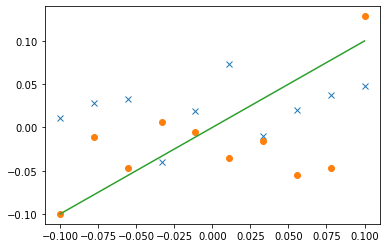

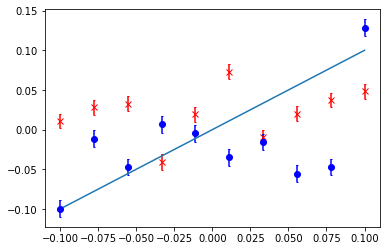

In [3]:
if cname=='ibmq_ehningen':
    Fx = np.load(str(cname+str("_LR_2022_3Q")+str("/")+str("_3Q_est")+str('_take_1_only_EM')+str("/")+str("all_data")+str(".npz")),allow_pickle=True)
else:
    
    Fx = np.load(str(cname+str("_LR_2022_3Q")+str("/")+str("_3Q_est")+str('_take_2_only_EM')+str("/")+str("all_data")+str(".npz")),allow_pickle=True)
#print(Fx)
data_load=Fx['arr_0']

Fs = np.load(str(str("ibmq_ehningen_LR_2022_3Q")+str("/")+str("_3Q_est")+str('_take_2_noEM')+str("/")+str("shot_string")+str(".npz")),allow_pickle=True)
#print(Fx)
tot_shots=Fs['arr_0']
#print(data_load)
#print(len(data_load))
#in the real thing this is 20,000
shotsEM=20000
#shotsEM=1000
shots_actual=2500
#in the real thing this is 100,000
shotsrun=120000
#shotsrun=1000
shotsper=np.round(512*2/3)
p=0.5
chiX1 = -0.1338;
chiX2 = 0.1338;
chiX3 = -2.4681;
chiX4 = 0.7817;
chiX5 =-0.7817;
chiX6 = 0.7156;
chiX7 =  -0.7156;
chiX8 = 2.4681;


chiY1 = -2.4680;
chiY2 =  2.4680;
chiY3 =0.1338;
chiY4 = 0.7157
chiY5 =-0.7157;
chiY6 = -0.7819;
chiY7 =  0.7819;
chiY8 = -0.1338;

#first load the error mitigation
thvec=np.linspace(-0.1,0.1,10)
estx_mit=[]
esty_mit=[]

counts_per_run=[]

scaling_prob_vec2=[]

EbarX=[]
EbarY=[]
for jj in range(10):
    data_int=data_load[jj*27:27+jj*27]
    shots_int=tot_shots[jj*27:27+jj*27]
    #then load all the counts
    count000=0
    count010=0
    count100=0
    count110=0
    count001=0
    count011=0
    count101=0
    count111=0
    scaling_prob_vec=[]
    for kk in range(27):
        
        #need a vector with the appropriate number of each measurement outcome for this particular circuit
        #then we will discard a certain amount to only leave #shots_int[kk] in total
        n000=data_int[kk].get('000',0)
        n010=data_int[kk].get('010',0)
        n100=data_int[kk].get('100',0)
        n110=data_int[kk].get('110',0)
        n001=data_int[kk].get('001',0)
        n011=data_int[kk].get('011',0)
        n101=data_int[kk].get('101',0)
        n111=data_int[kk].get('111',0)
        
        #then make the vector
        
        data1=np.ones(shots_actual)
        data1[:int(n000)] = 0
        data1[int(n000):int(n000)+int(n010)] = 1
        data1[int(n000)+int(n010):int(n000)+int(n010)+int(n100)] = 2
        data1[int(n000)+int(n010)+int(n100):int(n000)+int(n010)+int(n100)+int(n110)] = 3
        data1[int(n000)+int(n010)+int(n100)+int(n110):int(n000)+int(n010)+int(n100)+int(n110)+int(n001)] = 4
        data1[int(n000)+int(n010)+int(n100)+int(n110)+int(n001):int(n000)+int(n010)+int(n100)+int(n110)+int(n001)+int(n011)] = 5
        data1[int(n000)+int(n010)+int(n100)+int(n110)+int(n001)+int(n011):int(n000)+int(n010)+int(n100)+int(n110)+int(n001)+int(n011)+int(n101)] = 6
        data1[int(n000)+int(n010)+int(n100)+int(n110)+int(n001)+int(n011)+int(n101):int(n000)+int(n010)+int(n100)+int(n110)+int(n001)+int(n011)+int(n101)+int(n111)] = 7
        np.random.shuffle(data1)
        #only want this much data
        dataint=data1[0:shots_int[kk]]
        
        count000=count000+np.count_nonzero(dataint==0)
        count010=count010+np.count_nonzero(dataint==1)
        count100=count100+np.count_nonzero(dataint==2)
        count110=count110+np.count_nonzero(dataint==3)
        count001=count001+np.count_nonzero(dataint==4)
        count011=count011+np.count_nonzero(dataint==5)
        count101=count101+np.count_nonzero(dataint==6)
        count111=count111+np.count_nonzero(dataint==7)
        
        countsint=np.count_nonzero(dataint==0)+np.count_nonzero(dataint==1)+np.count_nonzero(dataint==2)+np.count_nonzero(dataint==3)+np.count_nonzero(dataint==4)+np.count_nonzero(dataint==5)+np.count_nonzero(dataint==6)+np.count_nonzero(dataint==7)
        if countsint !=shots_int[kk]:
            print("\033[1;31;40m  Error, something not right with counts    ")
    
    n1=count000
    n2=count001
    n3=count010
    n4=count011
    n5=count100
    n6=count101
    n7=count110
    n8=count111
    
    
    shots_temp=n1+n2+n3+n4+n5+n6+n7+n8
    estx=(chiX1*n1+chiX2*n2+chiX3*n3+chiX4*n4+chiX5*n5+chiX6*n6+chiX7*n7+chiX8*n8)*(1/shots_temp)
    esty=(chiY1*n1+chiY2*n2+chiY3*n3+chiY4*n4+chiY5*n5+chiY6*n6+chiY7*n7+chiY8*n8)*(1/shots_temp)
    
    
    estx_mit.append(estx)
    esty_mit.append(esty)
    
    #using this dat n1 -> n8; we can bootstrap to get an error bar on each estimate?
#     if shots_temp!=shotsEM:
#         print(shots_temp,shotsEM)
#         print('fook')
    nBootstrap=1000
    p1=n1/shots_temp
    p2=n2/shots_temp
    p3=n3/shots_temp
    p4=n4/shots_temp
    p5=n5/shots_temp
    p6=n6/shots_temp
    p7=n7/shots_temp
    p8=n8/shots_temp
    
    estx_BS=[]
    esty_BS=[]
    for hh in range(nBootstrap):
        rv= np.random.multinomial(shots_temp, [p1,p2,p3,p4,p5,p6,p7,p8], size=1)
        n1=rv[0][0]
        n2=rv[0][1]
        n3=rv[0][2]
        n4=rv[0][3]
        n5=rv[0][4]
        n6=rv[0][5]
        n7=rv[0][6]
        n8=rv[0][7]
        estx=(chiX1*n1+chiX2*n2+chiX3*n3+chiX4*n4+chiX5*n5+chiX6*n6+chiX7*n7+chiX8*n8)*(1/shots_temp)
        esty=(chiY1*n1+chiY2*n2+chiY3*n3+chiY4*n4+chiY5*n5+chiY6*n6+chiY7*n7+chiY8*n8)*(1/shots_temp)
        estx_BS.append(estx)
        esty_BS.append(esty)
    
    
    EbarX.append(np.std(estx_BS))
    EbarY.append(np.std(esty_BS))
plt.plot(thvec,estx_mit,'x')
plt.plot(thvec,esty_mit,'o')
plt.plot(thvec,thvec)
   
    
res3QXalt = stats.linregress(np.array(estx_mit),np.array(thvec))
res3QYalt = stats.linregress(np.array(esty_mit),np.array(thvec))

# print(res3QXalt.slope)
# print(res3QXalt.intercept)
# print(res3QYalt.slope)
# print(res3QYalt.intercept)

intX=np.mean(thvec-estx_mit)
intY=np.mean(thvec-esty_mit)

print('X intercept =',intX)
print('Y intercept =',intY)

print('x estimates = ',estx_mit)
print('error bars = ',EbarX)
print('y estimates = ',esty_mit)
print('error bars = ',EbarY)

plt.figure(2)
plt.errorbar(thvec,estx_mit,EbarX,marker='x',fmt=' ', color='r',capsize=1)
plt.errorbar(thvec,esty_mit,EbarY,marker='o',fmt=' ', color='b',capsize=1)
plt.plot(thvec,thvec)

In [8]:
print('x estimates = ',estx_mit)
print('error bars = ',EbarX)
print('y estimates = ',esty_mit)
print('error bars = ',EbarY)

x estimates =  [0.009806566313262691, 0.020181756351270255, 0.04596575815163033, 0.017388447689537928, 0.03857326965393078, 0.06201032206441286, 0.014430981196239232, 0.06421681836367268, 0.062136072214442874, 0.11253885777155433]
error bars =  [0.008825383765256177, 0.009154894651038088, 0.008872334225679018, 0.00893538529753508, 0.00952946740737288, 0.009119249584469972, 0.00887094892786085, 0.009108495241662143, 0.009508375607997789, 0.00943461238339874]
y estimates =  [-0.10069058311662335, -0.026850405081016163, -0.11281843368673736, -0.02893335667133427, 0.04884466893378673, -0.03621747349469893, -0.045250100020004, -0.061326865373074635, 0.00417984596919385, 0.0929291558311662]
error bars =  [0.010693318094981724, 0.010287318125419352, 0.010427429926814426, 0.010006139336603076, 0.010227278367053583, 0.009650231884206115, 0.010204059158691062, 0.010021007376665223, 0.009835257271381426, 0.010356484584868198]


In [9]:
shots_temp

19996

In [10]:
#then get second set of circuits for the next 
#now comparing the corrected and uncorrected results
import warnings
import random
from scipy import stats
warnings.filterwarnings('ignore', category=DeprecationWarning)
ii=complex(0,1)

#list of qubits you want to sample
qu1=12
qu2=13
qu3=14

#decoherence
p=0.5
shots=8192
shotseff=shots/3

#number of calibration states to try
thvec=np.linspace(-0.1,0.1,10)

#vector for storing all the circuits
tot_circs=[]
#vector for storing shot list
tot_shots=[]
#first run calibration

shotsEM=20000
shotsreal=120000

shotsreal=5550
# for jj in range(10):
#     thint=thvec[jj]
#     [circs_out,shots_out]=totcirc3Qnoise(thint,shotsEM,qu1,qu2,qu3,p)
#     for kk in range(len(circs_out)):
#         tot_circs.append(circs_out[kk])
#         tot_shots.append(shots_out[kk])
    
#then run real estimation
for kk in range(37):
    [circs_out,shots_out]=totcirc3Qnoise(0,shotsreal,qu1,qu2,qu3,p)
    
    for kk in range(len(circs_out)):
        tot_circs.append(circs_out[kk])
        tot_shots.append(shots_out[kk])

#then execute all at once
#job=execute(circs,qasm_sim,shots=shot_list)
Smax=np.max(tot_shots)
Smax=int(Smax)

print(Smax)

2341


MSE =  0.022392661095389444
Single-copy limit 0.015625
Two-copy limit 0.0126953125
Three-copy limit 0.0124205078125
infinite-copy limit 0.01171875


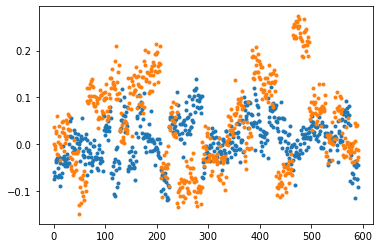

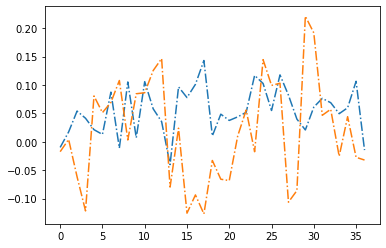

In [12]:
if cname=='ibmq_ehningen':
    Fx = np.load(str(cname+str("_LR_2022_3Q")+str("/")+str("_3Q_est")+str('_take_1_noEM')+str("/")+str("all_data")+str(".npz")),allow_pickle=True)
else:
    Fx = np.load(str(cname+str("_LR_2022_3Q")+str("/")+str("_3Q_est")+str('_take_2_noEM')+str("/")+str("all_data")+str(".npz")),allow_pickle=True)

    
    #print(Fx)
data_load=Fx['arr_0']
#print(data_load)
#print(len(data_load))
#in the real thing this is 20,000
shotsEM=20000
#shotsEM=1000
shots_actual=2341
#in the real thing this is 100,000
shotsrun=5550
#shotsrun=1000
shotsper=int(np.round(512*2/3))

grouping=int(shotsrun/shotsper)


p=0.5
chiX1 = -0.1338;
chiX2 = 0.1338;
chiX3 = -2.4681;
chiX4 = 0.7817;
chiX5 =-0.7817;
chiX6 = 0.7156;
chiX7 =  -0.7156;
chiX8 = 2.4681;


chiY1 = -2.4680;
chiY2 =  2.4680;
chiY3 =0.1338;
chiY4 = 0.7157
chiY5 =-0.7157;
chiY6 = -0.7819;
chiY7 =  0.7819;
chiY8 = -0.1338;

#first load the error mitigation
thvec=np.linspace(-0.1,0.1,10)
estx_mit=[]
esty_mit=[]

counts_per_run=[]

estx_vec_512=[]
esty_vec_512=[]

mse_vec=[]
msex_vec=[]
msey_vec=[]

mse_vec_EM=[]
msex_vec_EM=[]
msey_vec_EM=[]

mse_vec_EM_512=[]
msex_vec_EM_512=[]
msey_vec_EM_512=[]

tot_counts000=0
tot_counts010=0
tot_counts100=0
tot_counts110=0
tot_counts001=0
tot_counts011=0
tot_counts101=0
tot_counts111=0

estx37=[]
esty37=[]

for kk in range(37):
    
    count000=0
    count010=0
    count100=0
    count110=0
    count001=0
    count011=0
    count101=0
    count111=0
    
    data_int=data_load[8*kk:8+8*kk]
    shots_int=tot_shots[8*kk:8+8*kk]
    
    for hh in range(8):

        n000=data_int[hh].get('000',0)
        n010=data_int[hh].get('010',0)
        n100=data_int[hh].get('100',0)
        n110=data_int[hh].get('110',0)
        n001=data_int[hh].get('001',0)
        n011=data_int[hh].get('011',0)
        n101=data_int[hh].get('101',0)
        n111=data_int[hh].get('111',0)
        
        #then make the vector
        
        data1=np.ones(shots_actual)
        data1[:int(n000)] = 0
        data1[int(n000):int(n000)+int(n010)] = 1
        data1[int(n000)+int(n010):int(n000)+int(n010)+int(n100)] = 2
        data1[int(n000)+int(n010)+int(n100):int(n000)+int(n010)+int(n100)+int(n110)] = 3
        data1[int(n000)+int(n010)+int(n100)+int(n110):int(n000)+int(n010)+int(n100)+int(n110)+int(n001)] = 4
        data1[int(n000)+int(n010)+int(n100)+int(n110)+int(n001):int(n000)+int(n010)+int(n100)+int(n110)+int(n001)+int(n011)] = 5
        data1[int(n000)+int(n010)+int(n100)+int(n110)+int(n001)+int(n011):int(n000)+int(n010)+int(n100)+int(n110)+int(n001)+int(n011)+int(n101)] = 6
        data1[int(n000)+int(n010)+int(n100)+int(n110)+int(n001)+int(n011)+int(n101):int(n000)+int(n010)+int(n100)+int(n110)+int(n001)+int(n011)+int(n101)+int(n111)] = 7
        np.random.shuffle(data1)
        #only want this much data
        dataint=data1[0:shots_int[hh]]
        
        count000=count000+np.count_nonzero(dataint==0)
        count010=count010+np.count_nonzero(dataint==1)
        count100=count100+np.count_nonzero(dataint==2)
        count110=count110+np.count_nonzero(dataint==3)
        count001=count001+np.count_nonzero(dataint==4)
        count011=count011+np.count_nonzero(dataint==5)
        count101=count101+np.count_nonzero(dataint==6)
        count111=count111+np.count_nonzero(dataint==7)
        
        tot_counts000=tot_counts000+np.count_nonzero(dataint==0)
        tot_counts010=tot_counts010+np.count_nonzero(dataint==1)
        tot_counts100=tot_counts100+np.count_nonzero(dataint==2)
        tot_counts110=tot_counts110+np.count_nonzero(dataint==3)
        tot_counts001=tot_counts001+np.count_nonzero(dataint==4)
        tot_counts011=tot_counts011+np.count_nonzero(dataint==5)
        tot_counts101=tot_counts101+np.count_nonzero(dataint==6)
        tot_counts111=tot_counts111+np.count_nonzero(dataint==7)
        
        countsint=np.count_nonzero(dataint==0)+np.count_nonzero(dataint==1)+np.count_nonzero(dataint==2)+np.count_nonzero(dataint==3)+np.count_nonzero(dataint==4)+np.count_nonzero(dataint==5)+np.count_nonzero(dataint==6)+np.count_nonzero(dataint==7)
        if countsint !=shots_int[hh]:
            print("\033[1;31;40m  Error, something not right with EM counts   ")
            
        if n000+n100+n010+n110+n001+n101+n011+n111 != shots_actual:
            print("\033[1;31;40m  Error, something not right with EM counts   ")

            
            
    totcounts=  count000+count010+count100+count110+ count001+ count011+count101+count111
    #now make a vector of all the data
    n000=count000
    n010=count010
    n100=count100
    n110=count110
    n001=count001
    n011=count011
    n101=count101
    n111=count111
    
    n1=count000
    n2=count001
    n3=count010
    n4=count011
    n5=count100
    n6=count101
    n7=count110
    n8=count111

    estx=(chiX1*n1+chiX2*n2+chiX3*n3+chiX4*n4+chiX5*n5+chiX6*n6+chiX7*n7+chiX8*n8)*(1/(n1+n2+n3+n4+n5+n6+n7+n8))
    esty=(chiY1*n1+chiY2*n2+chiY3*n3+chiY4*n4+chiY5*n5+chiY6*n6+chiY7*n7+chiY8*n8)*(1/(n1+n2+n3+n4+n5+n6+n7+n8))
    estx37.append(estx)
    esty37.append(esty)

    #THEN SUB GROUP with each of the 37 estimates
#     if n000+n010+n100+n110+n001+n011+n101+n111 != shotsrun:
#         print(n000+n010+n100+n110+n001+n011+n101+n111,shotsrun)
#         print("\033[1;31;40m  Error, something not right with the counts from each estimate   ")
   
    
    estxtempO=[]
    estytempO=[]

    MSEtempO=[]
    #where does 10 come from? Random reshuffling just getting averaged
    for ll in range(10):
        shotsrunT=n000+n010+n100+n110+n001+n011+n101+n111
        data1=np.ones(shotsrunT)
        data1[:int(n000)] = 0
        data1[int(n000):int(n000)+int(n010)] = 1
        data1[int(n000)+int(n010):int(n000)+int(n010)+int(n100)] = 2
        data1[int(n000)+int(n010)+int(n100):int(n000)+int(n010)+int(n100)+int(n110)] = 3
        data1[int(n000)+int(n010)+int(n100)+int(n110):int(n000)+int(n010)+int(n100)+int(n110)+int(n001)] = 4
        data1[int(n000)+int(n010)+int(n100)+int(n110)+int(n001):int(n000)+int(n010)+int(n100)+int(n110)+int(n001)+int(n011)] = 5
        data1[int(n000)+int(n010)+int(n100)+int(n110)+int(n001)+int(n011):int(n000)+int(n010)+int(n100)+int(n110)+int(n001)+int(n011)+int(n101)] = 6
        data1[int(n000)+int(n010)+int(n100)+int(n110)+int(n001)+int(n011)+int(n101):int(n000)+int(n010)+int(n100)+int(n110)+int(n001)+int(n011)+int(n101)+int(n111)] = 7
        np.random.shuffle(data1)
        
        estxtemp=[]
        estytemp=[]

        MSEtemp=[]
        for hh in range(int(grouping)):
            dataint=data1[hh*shotsper:(hh+1)*shotsper]
            count000=np.count_nonzero(dataint==0)
            count010=np.count_nonzero(dataint==1)
            count100=np.count_nonzero(dataint==2)
            count110=np.count_nonzero(dataint==3)
            count001=np.count_nonzero(dataint==4)
            count011=np.count_nonzero(dataint==5)
            count101=np.count_nonzero(dataint==6)
            count111=np.count_nonzero(dataint==7)
            n1=count000
            n2=count001
            n3=count010
            n4=count011
            n5=count100
            n6=count101
            n7=count110
            n8=count111


            estx=(chiX1*n1+chiX2*n2+chiX3*n3+chiX4*n4+chiX5*n5+chiX6*n6+chiX7*n7+chiX8*n8)*(1/shotsper)
            esty=(chiY1*n1+chiY2*n2+chiY3*n3+chiY4*n4+chiY5*n5+chiY6*n6+chiY7*n7+chiY8*n8)*(1/shotsper)
            MSEtemp.append((estx+intX)**2+(esty+intY)**2)
            estxtemp.append(estx+intX)
            estytemp.append(esty+intY)
            
        estxtempO.append(estxtemp)
        estytempO.append(estytemp)
        MSEtempO.append(MSEtemp)
#     print(len(estxtempO))
#     print(len(np.mean(estxtempO,axis=0)))
#     stop
    estx_vec_512.append(np.mean(estxtempO,axis=0))
    esty_vec_512.append(np.mean(estytempO,axis=0))

    mse_vec_EM_512.append(np.mean(MSEtempO,axis=0))
#         msex_vec_EM_512.append((estx+intX)**2)
#         msey_vec_EM_512.append((esty+intY)**2)

mse_vec_EM_512=np.array(mse_vec_EM_512).flatten()
estx_vec_512=np.array(estx_vec_512).flatten()
esty_vec_512=np.array(esty_vec_512).flatten()
print('MSE = ', np.mean(mse_vec_EM_512))



shotseff=512
expvar3Q=12.7186/shotseff;

expvar=1/(((1-p)**2)*shotseff);
expvar2Q=2*(2-p+0.5*p**2)/(((1-p)**2)*shotseff);

hol=(4-2*p)/((1-p)**2*shotseff)
print('Single-copy limit',expvar*2)
print('Two-copy limit',expvar2Q/2)
print('Three-copy limit',expvar3Q/2)
print('infinite-copy limit',hol/2)

plt.figure(2)
plt.plot(estx_vec_512,'.')
plt.plot(esty_vec_512,'.')

plt.figure(3)
plt.plot(estx37,'-.')
plt.plot(esty37,'-.')


In [32]:
#bootstrapping based on the total counts

total_qubits=tot_counts000+tot_counts010+tot_counts100+tot_counts110+tot_counts001+tot_counts011+tot_counts101+tot_counts111

#print(total_qubits)
nRep=len(mse_vec_EM_512)
#print(nRep*512*2/3)

MSEtot=[]
MSEtot_EM=[]
nBootstrap=1000
for kk in range(nBootstrap):
    MSEint=[]
    MSE_EMint=[]
    for jj in range(nRep):
        rv= np.random.multinomial(shotsper, [p1,p2,p3,p4,p5,p6,p7,p8], size=1)
        n1=rv[0][0]
        n2=rv[0][1]
        n3=rv[0][2]
        n4=rv[0][3]
        n5=rv[0][4]
        n6=rv[0][5]
        n7=rv[0][6]
        n8=rv[0][7]
        estx=(chiX1*n1+chiX2*n2+chiX3*n3+chiX4*n4+chiX5*n5+chiX6*n6+chiX7*n7+chiX8*n8)*(1/shotsper)
        esty=(chiY1*n1+chiY2*n2+chiY3*n3+chiY4*n4+chiY5*n5+chiY6*n6+chiY7*n7+chiY8*n8)*(1/shotsper)
        MSEint.append(estx**2+esty**2)
        MSE_EMint.append((estx+intX)**2+(esty+intY)**2)
    MSEtot.append(np.mean(MSEint))
    MSEtot_EM.append(np.mean(MSE_EMint))
    
print('MSE = ',np.mean(MSEtot),'+/-',np.std(MSEtot))
print('MSE with EM = ',np.mean(MSEtot_EM),'+/-',np.std(MSEtot_EM))
    

MSE =  0.03247185603972616 +/- 0.001011162393504126
MSE with EM =  0.029995975948119372 +/- 0.0009626979515050804


In [29]:
#MSE's
#[auckland, guadalupe, mumbai,brooklyn]
MSEvec=[0.016358309342218127,0.02421012118157826,0.01622419848324652,0.016765877994590866]
MSEeb=[0.000455679447864367,0.0007409283496985263,0.0007201634403576756]
